In [2]:
import numpy as np
from itertools import combinations
from scipy.stats import entropy
import networkx as nx
import matplotlib.pyplot as plt


In [3]:
# יצירת סט נתונים בינארי לדוגמה
np.random.seed(42)  # לשחזור התוצאות
data = np.random.randint(0, 2, size=(100, 8))
labels = np.random.randint(0, 2, size=(100,))
dataset = np.column_stack((data, labels))


In [4]:
dataset

array([[0, 1, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 1],
       [1, 1, 1, 0, 1, 0, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 0, 0, 0],
       [1, 1, 1, 0, 1, 0, 0, 0, 1],
       [0, 0, 1, 1, 1, 1, 1, 0, 1],
       [1, 1, 0, 1, 0, 1, 0, 1, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 1, 1, 1, 1, 1],
       [0, 1, 0, 1, 1, 1, 0, 1, 0],
       [0, 1, 0, 1, 0, 0, 1, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 0, 0, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 0, 1, 0, 1],
       [1, 1, 0, 1, 0, 1, 1, 0, 1],
       [1, 0, 1, 0, 0, 1, 1, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 1, 1, 0],
       [1, 0, 0, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 1, 0, 1, 0, 1, 0],
       [0, 0, 1, 1, 1, 0, 1, 0, 0],
       [0, 1, 1, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 1],
       [0, 0, 1, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 0, 0, 1],
       [0, 1, 0, 0, 1, 0, 1, 1, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 1,

In [11]:
# חישוב השגיאה של עץ החלטה נתון
def calculate_error(tree, dataset):
    errors = 0
    for vector in dataset:
        current_node = tree
        while isinstance(current_node, dict):
            feature = next(iter(current_node))
            if vector[feature] in current_node[feature]:
                current_node = current_node[feature][vector[feature]]
            else:
                break
        if isinstance(current_node, dict) or current_node != vector[-1]:
            errors += 1
    return errors
# # חישוב השגיאה של עץ החלטה נתון
# def calculate_error(tree, dataset):
#     errors = 0
#     for vector in dataset:
#         current_node = tree
#         while isinstance(current_node, dict):
#             feature = next(iter(current_node))
#             if vector[feature] in current_node[feature]:
#                 current_node = current_node[feature][vector[feature]]
#             else:
#                 current_node = current_node[feature]
#         if current_node != vector[-1]:
#             errors += 1
#     return errors

# יצירת עץ החלטה באמצעות כוח גס
def brute_force_tree_search(dataset, k=3):
    n_dimensions = dataset.shape[1] - 1
    best_tree = None
    min_error = float('inf')

    for combination in combinations(range(n_dimensions), k):
        tree = {}
        for vector in dataset:
            current_node = tree
            for i in combination:
                if i not in current_node:
                    current_node[i] = {}
                if vector[i] not in current_node[i]:
                    current_node[i][vector[i]] = {}
                current_node = current_node[i][vector[i]]
            current_node['label'] = vector[-1]
        
        def simplify_tree(node):
            if 'label' in node:
                return node['label']
            else:
                return {key: simplify_tree(value) for key, value in node.items()}
        
        simplified_tree = simplify_tree(tree)
        error = calculate_error(simplified_tree, dataset)
        if error < min_error:
            min_error = error
            best_tree = simplified_tree
    
    return best_tree, min_error


In [16]:

# חישוב אנטרופיה בינארית
def binary_entropy(labels):
    if len(labels) == 0:
        return 0
    _, counts = np.unique(labels, return_counts=True)
    probabilities = counts / len(labels)
    return entropy(probabilities, base=2)

# פיצול נתונים לפי האנטרופיה המינימלית
def best_split(dataset):
    n_dimensions = dataset.shape[1] - 1
    min_entropy = float('inf')
    best_dimension = -1

    for dimension in range(n_dimensions):
        left_labels = dataset[dataset[:, dimension] == 0][:, -1]
        right_labels = dataset[dataset[:, dimension] == 1][:, -1]
        entropy_sum = binary_entropy(left_labels) + binary_entropy(right_labels)
        if entropy_sum < min_entropy:
            min_entropy = entropy_sum
            best_dimension = dimension
    
    return best_dimension

# # בניית עץ החלטה
# def build_tree(dataset, k, current_depth=0):
#     if current_depth == k or len(np.unique(dataset[:, -1])) == 1:
#         return np.bincount(dataset[:, -1]).argmax()
    
#     best_dim = best_split(dataset)
#     if best_dim == -1:
#         return np.bincount(dataset[:, -1]).argmax()
    
#     tree = {best_dim: {}}
    
#     left_subset = dataset[dataset[:, best_dim] == 0]
#     right_subset = dataset[dataset[:, best_dim] == 1]
    
#     tree[best_dim][0] = build_tree(left_subset, k, current_depth + 1) if len(left_subset) > 0 else np.bincount(dataset[:, -1]).argmax()
#     tree[best_dim][1] = build_tree(right_subset, k, current_depth + 1) if len(right_subset) > 0 else np.bincount(dataset[:, -1]).argmax()
    
#     return tree
# # בניית עץ החלטה
def build_tree(dataset, k):
    if k == 0 or len(np.unique(dataset[:, -1])) == 1:
        return np.bincount(dataset[:, -1]).argmax()
    
    best_dim = best_split(dataset)
    if best_dim == -1:
        return np.bincount(dataset[:, -1]).argmax()
    
    tree = {best_dim: {}}
    
    left_subset = dataset[dataset[:, best_dim] == 0]
    right_subset = dataset[dataset[:, best_dim] == 1]
    
    if len(left_subset) > 0:
        tree[best_dim][0] = build_tree(left_subset, k - 1)
    else:
        tree[best_dim][0] = np.bincount(dataset[:, -1]).argmax()
    
    if len(right_subset) > 0:
        tree[best_dim][1] = build_tree(right_subset, k - 1)
    else:
        tree[best_dim][1] = np.bincount(dataset[:, -1]).argmax()
    
    return tree

# הרצת עץ החלטה באמצעות אנטרופיה בינארית
def binary_entropy_tree_search(dataset, k=3):
    tree = build_tree(dataset, k)
    error = calculate_error(tree, dataset)
    return tree, error


In [17]:
# הרצת האלגוריתמים והשוואת התוצאות
brute_force_tree, brute_force_error = brute_force_tree_search(dataset, k=3)
print("Brute-force tree error:", brute_force_error)
print("Brute-force tree:", brute_force_tree)

Brute-force tree error: 36
Brute-force tree: {0: {0: {2: {0: {7: {0: 0, 1: 0}}, 1: {7: {0: 0, 1: 1}}}}, 1: {2: {1: {7: {1: 1, 0: 1}}, 0: {7: {1: 0, 0: 1}}}}}}


In [18]:

binary_entropy_tree, binary_entropy_error = binary_entropy_tree_search(dataset, k=3)
print("Binary entropy tree error:", binary_entropy_error)
print("Binary entropy tree:", binary_entropy_tree)

Binary entropy tree error: 42
Binary entropy tree: {4: {0: {4: {0: {4: {0: 0, 1: 0}}, 1: 0}}, 1: {4: {0: 1, 1: {4: {0: 1, 1: 1}}}}}}


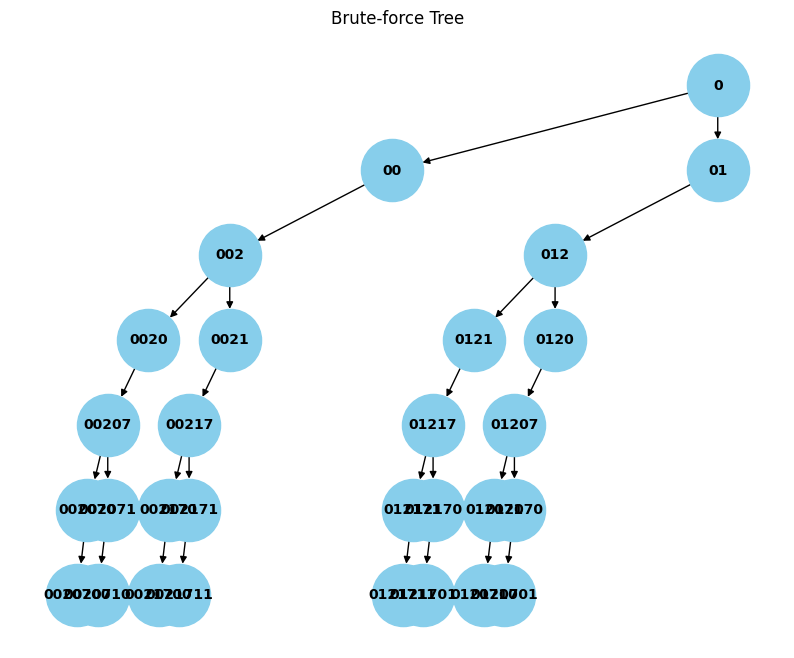

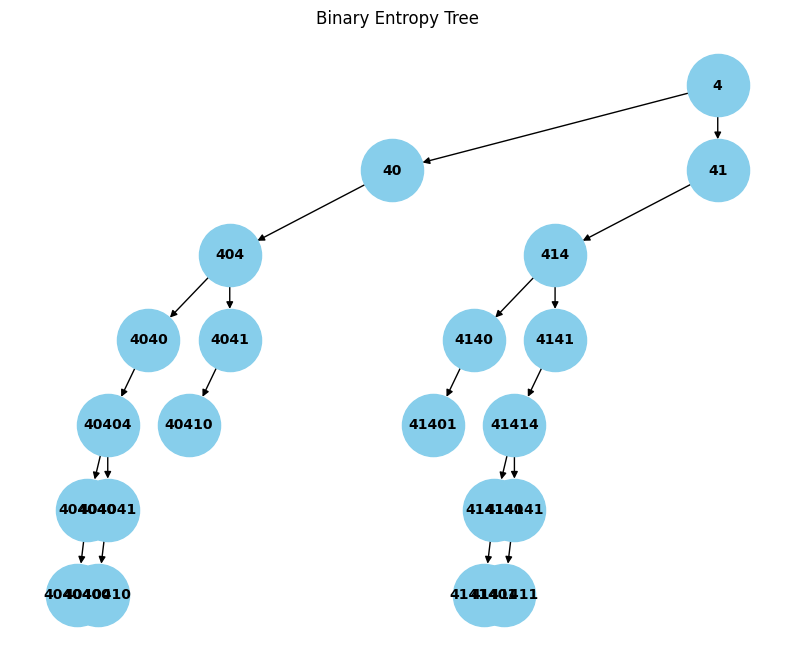

In [19]:

def plot_tree(tree, parent_name='', graph=None, level=0, pos=None, x=0, y=0, layer_width=2):
    if graph is None:
        graph = nx.DiGraph()
        pos = {}
    if isinstance(tree, dict):
        for key, subtree in tree.items():
            node_name = f"{parent_name}{key}"
            graph.add_node(node_name)
            pos[node_name] = (x, y)
            if parent_name:
                graph.add_edge(parent_name, node_name)
            next_x = x - layer_width / 2 ** (level + 1)
            plot_tree(subtree, node_name, graph, level + 1, pos, next_x, y - 1, layer_width)
            x += layer_width / 2 ** level
    else:
        node_name = f"{parent_name}{tree}"
        graph.add_node(node_name)
        pos[node_name] = (x, y)
        if parent_name:
            graph.add_edge(parent_name, node_name)
    return graph, pos

def draw_tree(tree, title="Decision Tree"):
    graph, pos = plot_tree(tree)
    fig, ax = plt.subplots(figsize=(10, 8))
    nx.draw(graph, pos, with_labels=True, ax=ax, node_size=2000, node_color="skyblue", font_size=10, font_weight="bold")
    plt.title(title)
    plt.show()

# שרטוט העצים
draw_tree(brute_force_tree, title="Brute-force Tree")
draw_tree(binary_entropy_tree, title="Binary Entropy Tree")